In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
words = open("../data/names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [14]:
# build the data

block_size = 3 # how many characters do we need to predict the next one?
X, Y = [], []
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # crop and append
        #print(ix)
X = torch.tensor(X)
Y = torch.tensor(Y)

In [15]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [17]:
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(123)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtrain, Ytrain  = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182465, 3]) torch.Size([182465])
torch.Size([22817, 3]) torch.Size([22817])
torch.Size([22864, 3]) torch.Size([22864])


In [18]:
# look-up table C
C = torch.randn((27, 2))

In [19]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [20]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [21]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [22]:
h

tensor([[ 0.0774,  0.3871,  0.0299,  ...,  0.9473, -0.9966, -0.9458],
        [-0.3896,  0.1422,  0.0228,  ...,  0.9616, -0.9980, -0.9212],
        [ 0.9912,  0.9830,  0.2768,  ...,  0.6668, -0.9064, -0.9968],
        ...,
        [ 0.9563,  0.2979, -0.0113,  ...,  0.8996, -0.9817, -0.9853],
        [-0.1798, -0.9611,  0.1026,  ...,  0.9998, -0.9989, -0.7096],
        [ 0.9994,  0.8106, -0.5263,  ..., -0.5180,  0.9026, -0.9321]])

In [23]:
h.shape

torch.Size([228146, 100])

In [24]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [25]:
logits = h @ W2 + b2 

In [26]:
logits.shape

torch.Size([228146, 27])

In [27]:
counts = logits.exp()

In [28]:
counts

tensor([[1.2215e-03, 4.8818e-02, 4.0253e+06,  ..., 2.5175e-02, 2.3340e-01,
         2.1873e+01],
        [1.5001e-03, 1.6424e+00, 5.0807e+06,  ..., 1.6169e-03, 5.5943e-01,
         1.8184e+02],
        [1.7137e-01, 1.1681e-05, 1.8057e+01,  ..., 1.0668e+01, 2.3276e+00,
         7.1661e-07],
        ...,
        [8.4435e+03, 2.4926e-01, 2.3679e+05,  ..., 2.6301e-01, 4.6018e-08,
         2.2991e-06],
        [1.1285e-03, 2.8336e+04, 2.1629e-02,  ..., 7.6440e+01, 1.2747e-03,
         3.1807e+02],
        [8.3485e+03, 5.3749e-06, 2.6484e+01,  ..., 7.9792e-01, 2.3095e-01,
         4.9585e-06]])

In [29]:
prob = counts / counts.sum(1, keepdims=True)

In [30]:
prob.shape

torch.Size([228146, 27])

In [37]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [33]:
# --- ZUSAMMENFASSUNG --- #

In [34]:
Xtrain.shape, Ytrain.shape

(torch.Size([182465, 3]), torch.Size([182465]))

In [44]:
# --- ALL PARAMETERS --- #
g = torch.Generator().manual_seed(123) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [45]:
sum(p.nelement() for p in parameters)

11897

In [46]:
for p in parameters:
    p.requires_grad = True

In [47]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [48]:
lri = []
lossi = []
stepi = []

In [50]:
for i in range(200_000):

    # minibatch construct 
    ix = torch.randint(0, Xtrain.shape[0], (32,))

    # forward pass
    emb = C[Xtrain[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytrain[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

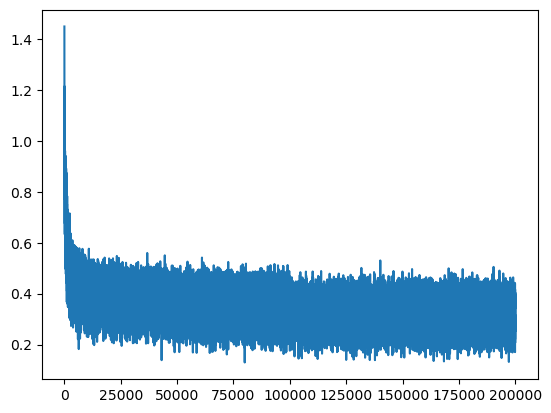

In [51]:
plt.plot(stepi, lossi)

In [52]:
emb = C[Xtrain] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(2.1153, grad_fn=<NllLossBackward0>)

In [53]:
emb = C[Xval] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1570, grad_fn=<NllLossBackward0>)

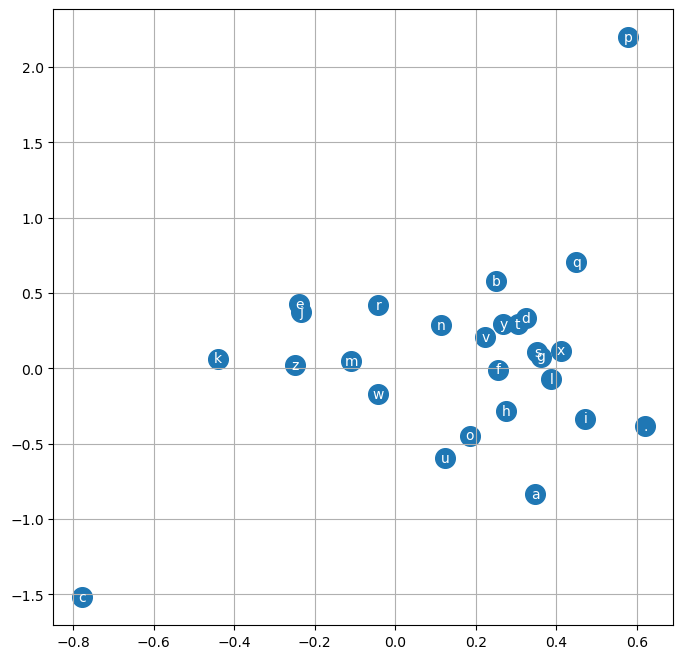

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [55]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))